# Multiclass classification with CNN and pre-trained word embeddings

#### Aaron Anderson

This notebook presents a working example of a classification problem using a convolutional neural network architecture that exploits pre-trained word embeddings from Google's word2vec.

---
### 1. Imports

In [41]:
import numpy as np
import pandas as pd
import string
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, concatenate, Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPooling1D, BatchNormalization, Flatten
from sklearn.naive_bayes import GaussianNB
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models.keyedvectors import KeyedVectors

---
### 2. Load labeled data

In [102]:
df = pd.read_csv('labeled_data.csv')
df = df.dropna(subset = ['topics', 'text'])
display(df.head())
print(f'The data has {df.shape[0]} rows.')

/Users/aaronanderson/NWRC/Venv/cnn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,1,2,10,11,18,22,23,25,26,28,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Identity,topics,sentiment,created_at,text,user_loc,user_desc,coords,geo,place,...,user_lang,user_following,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,source_file
0,conservative,control,-1,Sat Jun 01 03:59:44 +0000 2019,(Agricultural) DIVERSITY is OUR STRENGTH... #t...,"Ottawa, Ontario",11th Gen. Cdn. (1653) Conservative. Retired sm...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_feralswine_05012019to11042019.csv
1,She,concern,0,Tue Aug 06 17:39:49 +0000 2019,People posted the O RLY owl for like three yea...,Ebou Dar,She/Her ~ Somewhere on the ace/aro spectrum ~ ...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_wildpigs_05012019to11042019.csv
2,Student,info,0,Tue Aug 06 07:31:55 +0000 2019,I fight back the tears at my children's funera...,"Tucson, AZ",Like all of my tweets are going to be video g...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_wildpigs_05012019to11042019.csv
3,Farmer,concern,-1,Sun May 26 20:59:04 +0000 2019,Feral swine amassed at Montana‚Äôs northern bo...,New York State,"Female dairy farmer (4th generation), assistan...",NaN,NaN,NaN,...,NaN,NaN,NaN,False,11,21,False,False,en,results_feralswine_05012019to11042019.csv
4,"Reporter, Military",concern,-1,Wed Aug 07 18:19:35 +0000 2019,What a sentence by @AlexHortonTX: Millions of ...,Washington,Reporter @washingtonpost. Formerly at @starsan...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_wildhogs_05012019to11042019.csv


The data has 1360 rows.


In [103]:
pd.unique(df['topics'])
df['topic_1'] = df.topics.str.split(',', expand=True).loc[:, 0]
df['topic_1'] = df['topic_1'].str.strip()
df['topic_1'] = df['topic_1'].str.lower()

In [104]:
category = np.array(df['topic_1'])
texts = np.array(df['text'])

In [151]:
for topic in pd.unique(df.topic_1):
    print(f'{topic} = {round(np.sum(df.topic_1 == topic) / df.shape[0], 3)}')
    
unique_topics = pd.unique(df.topic_1)

label_dict = {}
for i in range(len(unique_topics)):
    label_dict[unique_topics[i]] = i

control = 0.007
concern = 0.141
info = 0.038
30-50 = 0.179
benefit = 0.019
injurehumans = 0.007
0 = 0.304
asf = 0.017
damproperty = 0.001
basmen = 0.077
weaponsused = 0.023
petition = 0.031
jobpost = 0.001
relate = 0.007
scary = 0.01
persexperience = 0.029
news = 0.004
question = 0.016
perexperience = 0.002
humor = 0.008
hunting = 0.02
location = 0.01
food = 0.001
recactiv = 0.002
reportsight = 0.004
usda = 0.007
release = 0.001
damcrops = 0.001
unsure = 0.011
combat = 0.001
disease = 0.004
research = 0.006
injurehuman = 0.001
reactiv = 0.001
petititon = 0.001
movement = 0.001
trailcam = 0.001
sellbuy = 0.001
prop4sale = 0.001
misinfo = 0.001
gear = 0.001
wildlife services = 0.001
weapsonsused = 0.001
{'control': 0, 'concern': 1, 'info': 2, '30-50': 3, 'benefit': 4, 'injurehumans': 5, '0': 6, 'asf': 7, 'damproperty': 8, 'basmen': 9, 'weaponsused': 10, 'petition': 11, 'jobpost': 12, 'relate': 13, 'scary': 14, 'persexperience': 15, 'news': 16, 'question': 17, 'perexperience': 18, 'humor'

---
### 3. Functions for data organization

In [152]:
def split_sample(category, texts, val_start, val_end):
    """ Splits both sentiment and texts arrays into validation and train arrays. """
    
    category_val = category[val_start:val_end + 1]
    texts_val = texts[val_start:val_end + 1]
    category_train = np.delete(category, range(val_start, val_end + 1))
    texts_train = np.delete(texts, range(val_start, val_end + 1))
    
    return category_val, texts_val, category_train, texts_train

In [153]:
def y_to_int(category_val, category_train, label_dict):
    """ Convert y vectors to 0, 1 vectors. """
    #le = preprocessing.LabelEncoder()
    #full_set = np.concatenate([category_val, category_train])
    #le.fit(full_set)
    #labels_val = le.transform(category_val)
    #labels_train = le.transform(category_train)
    
    labels_val = np.zeros(len(category_val), dtype=np.int8)
    labels_train = np.zeros(len(category_train), dtype=np.int8)
    
    for i in range(len(category_val)):
        labels_val[i] = label_dict[category_val[i]]
    for i in range(len(category_train)):
        labels_train[i] = label_dict[category_train[i]]
           
    
    return labels_val, labels_train

In [154]:
def get_bow_matrix(x_train, x_val, NUM_WORDS, MAX_SEQUENCE_LENGTH):
    """ Build bow matrix from x data. """
    x_train_bow = np.zeros((x_train.shape[0], NUM_WORDS + 1))
    x_val_bow = np.zeros((x_val.shape[0], NUM_WORDS + 1))

    for i in range(x_train.shape[0]):
        for j in range(MAX_SEQUENCE_LENGTH):
            x_train_bow[i, x_train[i, j]] = 1

    for i in range(x_val.shape[0]):
        for j in range(MAX_SEQUENCE_LENGTH):
            x_val_bow[i, x_val[i, j]] = 1
            
    return x_val_bow, x_train_bow

In [155]:
def build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH=None):
    """ Get sequences associated with rows (integer number of words). """
    tokenizer = Tokenizer(num_words=NUM_WORDS, lower=True)
    tokenizer.fit_on_texts(texts_train)
    sequences_train = tokenizer.texts_to_sequences(texts_train)
    if texts_val is not None:
        sequences_val = tokenizer.texts_to_sequences(texts_val)
    
    if MAX_SEQUENCE_LENGTH is None:
        MAX_SEQUENCE_LENGTH = 0
        for sequence in sequences_train:
            if len(sequence) > MAX_SEQUENCE_LENGTH:
                MAX_SEQUENCE_LENGTH = len(sequence)
        # print('Max sequence len =', MAX_SEQUENCE_LENGTH)
    
    word_index = tokenizer.word_index
    # print('Found %s unique tokens' % len(word_index))

    data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
    if texts_val is not None:
        data_val = pad_sequences(sequences_val, maxlen=MAX_SEQUENCE_LENGTH)
    else:
        data_val = None
    
    return data_val, data_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer

---
### 4. Functions to get word embeddings

Consider the phrases 'have a good time' and 'have a great time'. We need some way to represent these numerically. One-hot encoding based on bag-of-words (BOW) is a conventional technique. In this example, our BOW is `(have, a, good, great, time)`. If we represent a single word with a vector of these elements we would have: <br>
* `[1, 0, 0, 0, 0]` for 'have'
* `[0, 0, 1, 0, 0]` for 'good'
* `[0, 0, 0, 1, 0]` for 'great'

The shortcoming of this representation is that the distance (in 5-dimensional space) between 'have' and 'good' is exactly the same as the distance between 'good' and 'great'. Yet we know that 'have' and 'good' have very different meanings and 'good' and 'great' have very similar meanings.  

What we would like is a vector representation of a word that is similar to the vectors that represent different words that appear in similar contexts. Google's Word2Vec is a method to construct these vectors. Consider the following neural network architecture:

<img src="images/Skipgram.png" alt="Drawing" style="width: 500px;"/>

The input is a one-hot vector for 'good', and the output is series of one-hot vectors for context words. Essentially, we are feeding the network a target word and predicting context information. If we were to train this network on large amounts of written text, it would learn the vector representation of each target word. In fact, the vector representation (the embedding) is the vector __h__ associated with the word. Since words with similar meanings tend to appear in similar contexts, the embeddings for similar words will be similar vectors.

In [156]:
def get_embedding_index(glove=True):

    if glove:
        GLOVE_DIR = '../classify-text/embeddings/glove.twitter.27B'
        embeddings_index = {}
        f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'))
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
    else:
        filepath = "../classify-text/embeddings/GoogleNews-vectors-negative300.bin"
        embeddings_index = {}
        wv_from_bin = KeyedVectors.load_word2vec_format(filepath, binary=True) 
        for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
            coefs = np.asarray(vector, dtype='float32')
            embeddings_index[word] = coefs

    return embeddings_index

In [157]:
def get_embedding_matrix(EMBEDDING_DIM, word_index, embeddings_index):

    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # print(embedding_matrix.shape)
    return embedding_matrix

---
### 5. Functions for evaluating simple algorithms

In [158]:
def get_rf_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = RandomForestClassifier(n_estimators=500, min_samples_split=4)
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('RF training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('RF validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    
    return acc

In [159]:
def get_nb_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = GaussianNB()
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('NB training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('NB validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    
    return acc

In [160]:
def get_svm_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = svm.SVC(kernel='linear')
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('SVM training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('SVM validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    
    return acc

In [161]:
def get_logit_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto', max_iter=5000)
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('Logit training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('Logit validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    
    return acc

In [162]:
def get_mlp_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=x_train_bow.shape[1]))
    model.add(Dropout(0.50))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(unique_topics), activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train_bow, y_train,
              batch_size=1280,
              epochs=125,
              validation_data=(x_val_bow, y_val),
              verbose=False)
    
    y_pred_val = model.predict_classes(x_val_bow)
    print('MLP validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    
    return acc

---
### 7. Evaluation of simple BOW methods

We need to set aside a portion of our data to test our trained algorithm. We could set aside a single validation set, but suppose we happen to draw a random selection of observations for the validation set that are particularly easy (or difficult) to classify? The solution is to use a procedure called k-fold cross-validation to ensure that all observations appear in the validation set exactly once.

<img src="images/kfold.png" alt="Drawing" style="width: 600px;"/>

In [164]:
NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = None

rf = {'acc': []}
nb = {'acc': []}
sv = {'acc': []}
logit = {'acc': []}
mlp = {'acc': []}

for k in range(0, 5):
    print('')
    print('Validation on fold ' + str(k + 1) + '.')
    val_start = round(df.shape[0] * k / 5)
    val_end = round(df.shape[0] * (k + 1) / 5) - 1

    category_val, texts_val, category_train, texts_train = split_sample(category, texts, val_start, val_end)

    x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH)

    y_val, y_train = y_to_int(category_val, category_train, label_dict)

    x_val_bow, x_train_bow = get_bow_matrix(x_train, x_val, NUM_WORDS, MAX_SEQUENCE_LENGTH)
    
    acc = get_rf_acc(x_train_bow, y_train, x_val_bow, y_val)
    rf['acc'].append(acc)
    
    acc = get_nb_acc(x_train_bow, y_train, x_val_bow, y_val)
    nb['acc'].append(acc)
    
    acc = get_svm_acc(x_train_bow, y_train, x_val_bow, y_val)
    sv['acc'].append(acc)
    
    acc = get_logit_acc(x_train_bow, y_train, x_val_bow, y_val)
    logit['acc'].append(acc)
    
    acc = get_mlp_acc(x_train_bow, y_train, x_val_bow, y_val)
    mlp['acc'].append(acc) 


Validation on fold 1.
RF validation accuracy = 0.636
NB validation accuracy = 0.463
SVM validation accuracy = 0.599
Logit validation accuracy = 0.607
MLP validation accuracy = 0.577

Validation on fold 2.
RF validation accuracy = 0.669
NB validation accuracy = 0.474
SVM validation accuracy = 0.658
Logit validation accuracy = 0.676
MLP validation accuracy = 0.61

Validation on fold 3.
RF validation accuracy = 0.699
NB validation accuracy = 0.496
SVM validation accuracy = 0.68
Logit validation accuracy = 0.691
MLP validation accuracy = 0.654

Validation on fold 4.
RF validation accuracy = 0.68
NB validation accuracy = 0.496
SVM validation accuracy = 0.673
Logit validation accuracy = 0.691
MLP validation accuracy = 0.654

Validation on fold 5.
RF validation accuracy = 0.618
NB validation accuracy = 0.434
SVM validation accuracy = 0.61
Logit validation accuracy = 0.621
MLP validation accuracy = 0.592


In [165]:
print('ACCURACY')
print('random forest =', round(np.mean(rf['acc']), 3))
print('naive bayes =', round(np.mean(nb['acc']), 3))
print('support vector =', round(np.mean(sv['acc']), 3))
print('logit regress =', round(np.mean(logit['acc']), 3))
print('standard mlp =', round(np.mean(mlp['acc']), 3))

ACCURACY
random forest = 0.66
naive bayes = 0.473
support vector = 0.644
logit regress = 0.657
standard mlp = 0.618


---
### 8. Evaluation of CNN with word2vec embeddings

Convolutional neural networks are common architectures in computer vision tasks due to the very large number of features associated with each sample. Consider a relatively small color image that is 100x100 pixels. This image would contain 30,000 features (100 * 100 * 3 color channels). If we were were to assemble a conventional neural network with a single dense hidden layer of 100 nodes, we would have (30000 * 100 + 1) + (100 + 1) parameters to estimate. 

Our problem is not as extreme as some image problems, but we still have a large number of features. For example, we might allow a sequence length of 50 and have word embedding vectors that contain 300 elements. Thus, each tweet is represented by 50 * 300 features. 

To understand how a convolutional network reduces the number of trainable parameters, consider:

<img src="images/filter.png" alt="Drawing" style="width: 600px;"/>

In this very simple example, we slide a filter over the data representing a single tweet. The filter contains a number of parameters equal to 3 times the length of the embedding vectors (7 in this case). So, instead of estimating weights on 56 features, we train 21 weights in the filter. In practice, our sequence are much longer so that the benefits of a CNN are more pronounces.

The architecture we use is demonstrated in the figure below. We start with an embedding layer and feed the output of that layer into a 1d convolutional layer. We then use max pooling before a a fully-connected layer. The activation functions for both the convolutional and dense layers are RELU, and our final activation is softmax.

![](images/cnn.png)


In [166]:
embeddings_index_google = get_embedding_index(glove=False)

In [167]:
def fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, 
                  HIDDEN_DIMS, EPOCHS, DROPOUT_RATE, MAX_SEQUENCE_LENGTH, 
                  x_train, y_train, x_val, y_val, word_index, embedding_matrix, verbose):

    tweet_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    tweet_encoder = Embedding(len(word_index) + 1, EMBEDDING_DIMS, weights=[embedding_matrix], 
                              input_length=MAX_SEQUENCE_LENGTH, trainable=False)(tweet_input)
    bigram_branch = Conv1D(filters=FILTERS, kernel_size=2, padding='valid', 
                           activation='relu', strides=1)(tweet_encoder)
    bigram_branch = GlobalMaxPooling1D()(bigram_branch)
    trigram_branch = Conv1D(filters=FILTERS, kernel_size=3, padding='valid', 
                            activation='relu', strides=1)(tweet_encoder)
    trigram_branch = GlobalMaxPooling1D()(trigram_branch)
    fourgram_branch = Conv1D(filters=FILTERS , kernel_size=4, padding='valid', 
                             activation='relu', strides=1)(tweet_encoder)
    fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
    
    merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

    merged = Dense(HIDDEN_DIMS, activation='relu')(merged)
    merged = Dropout(DROPOUT_RATE)(merged)
    merged = Dense(len(unique_topics))(merged)
    
    output = Activation('softmax')(merged)
    model = Model(inputs=[tweet_input], outputs=[output])
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    # print(model.summary())

    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(x_val, y_val),
                        verbose=verbose)
    
    score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=False)
    print('CNN validation accuracy:', acc)
    
    probs = model.predict(x_val, batch_size=BATCH_SIZE, verbose=False)
    fitted = np.argmax(probs, axis=1)


        
    return acc, history, probs, fitted

In [169]:
MAX_SEQUENCE_LENGTH = None
EMBEDDING_DIMS = 300
NUM_WORDS = 1000
BATCH_SIZE = 1280
FILTERS = 32
HIDDEN_DIMS = 128
EPOCHS = 125
DROPOUT_RATE = 0.5

cnn1 = {'acc': []}
histories = []
y_val_list = []
fitted_list = []
probs_list = []

for k in range(0, 5):
    print('')
    print('Validation on fold ' + str(k + 1) + '.')
    val_start = round(df.shape[0] * k / 5)
    val_end = round(df.shape[0] * (k + 1) / 5) - 1
    
    category_val, texts_val, category_train, texts_train = split_sample(category, texts, val_start, val_end)

    x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH)

    y_val, y_train = y_to_int(category_val, category_train, label_dict)

    # print('Validation data shape =', x_val.shape)
    # print('Train data shape =', x_train.shape)

    # print('Validation labels shape =', y_val.shape)
    # print('Train labels shape =', y_train.shape)

    embedding_matrix = get_embedding_matrix(EMBEDDING_DIMS, word_index, embeddings_index_google)

    acc, history, probs, fitted = fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, HIDDEN_DIMS, 
                                                EPOCHS, DROPOUT_RATE, MAX_SEQUENCE_LENGTH,
                                                x_train, y_train, x_val, y_val, 
                                                word_index, embedding_matrix, verbose=False)

    fitted_list.append(fitted)
    y_val_list.append(y_val)
    probs_list.append(probs)
    histories.append(history)
    cnn1['acc'].append(acc)


Validation on fold 1.
CNN validation accuracy: 0.6213235259056091

Validation on fold 2.
CNN validation accuracy: 0.6360294222831726

Validation on fold 3.
CNN validation accuracy: 0.6985294222831726

Validation on fold 4.
CNN validation accuracy: 0.6875

Validation on fold 5.
CNN validation accuracy: 0.6507353186607361


<IPython.core.display.Javascript object>


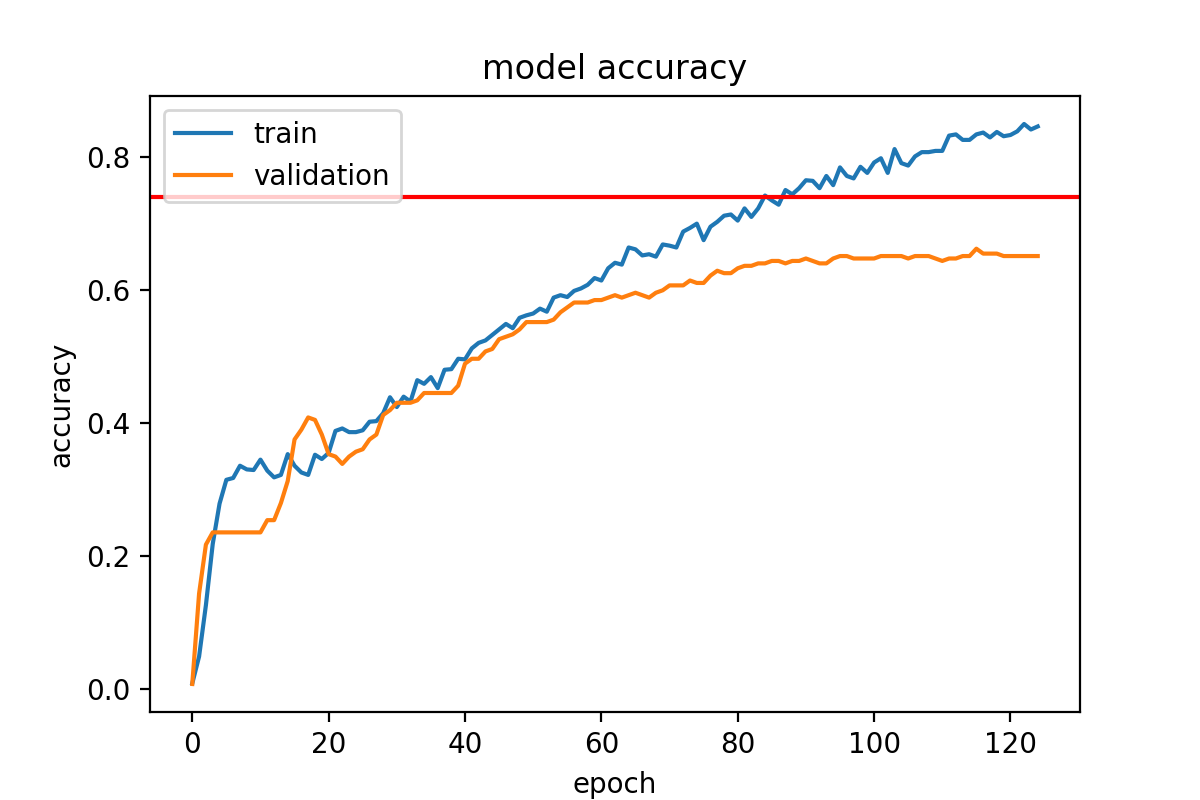

In [170]:
fold = 4

plt.rcParams['figure.figsize'] = [6, 4]

%matplotlib notebook
plt.plot(histories[fold].history['accuracy'])
plt.plot(histories[fold].history['val_accuracy'])
plt.axhline(y=0.74, color='r', linestyle='-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [171]:
print('ACCURACY')
print('cnn1 =', round(np.mean(cnn1['acc']), 3))
print('')

ACCURACY
cnn1 = 0.659



In [178]:
list(label_dict.keys())[list(label_dict.values()).index(0)]
y_val[0]

0

<IPython.core.display.Javascript object>


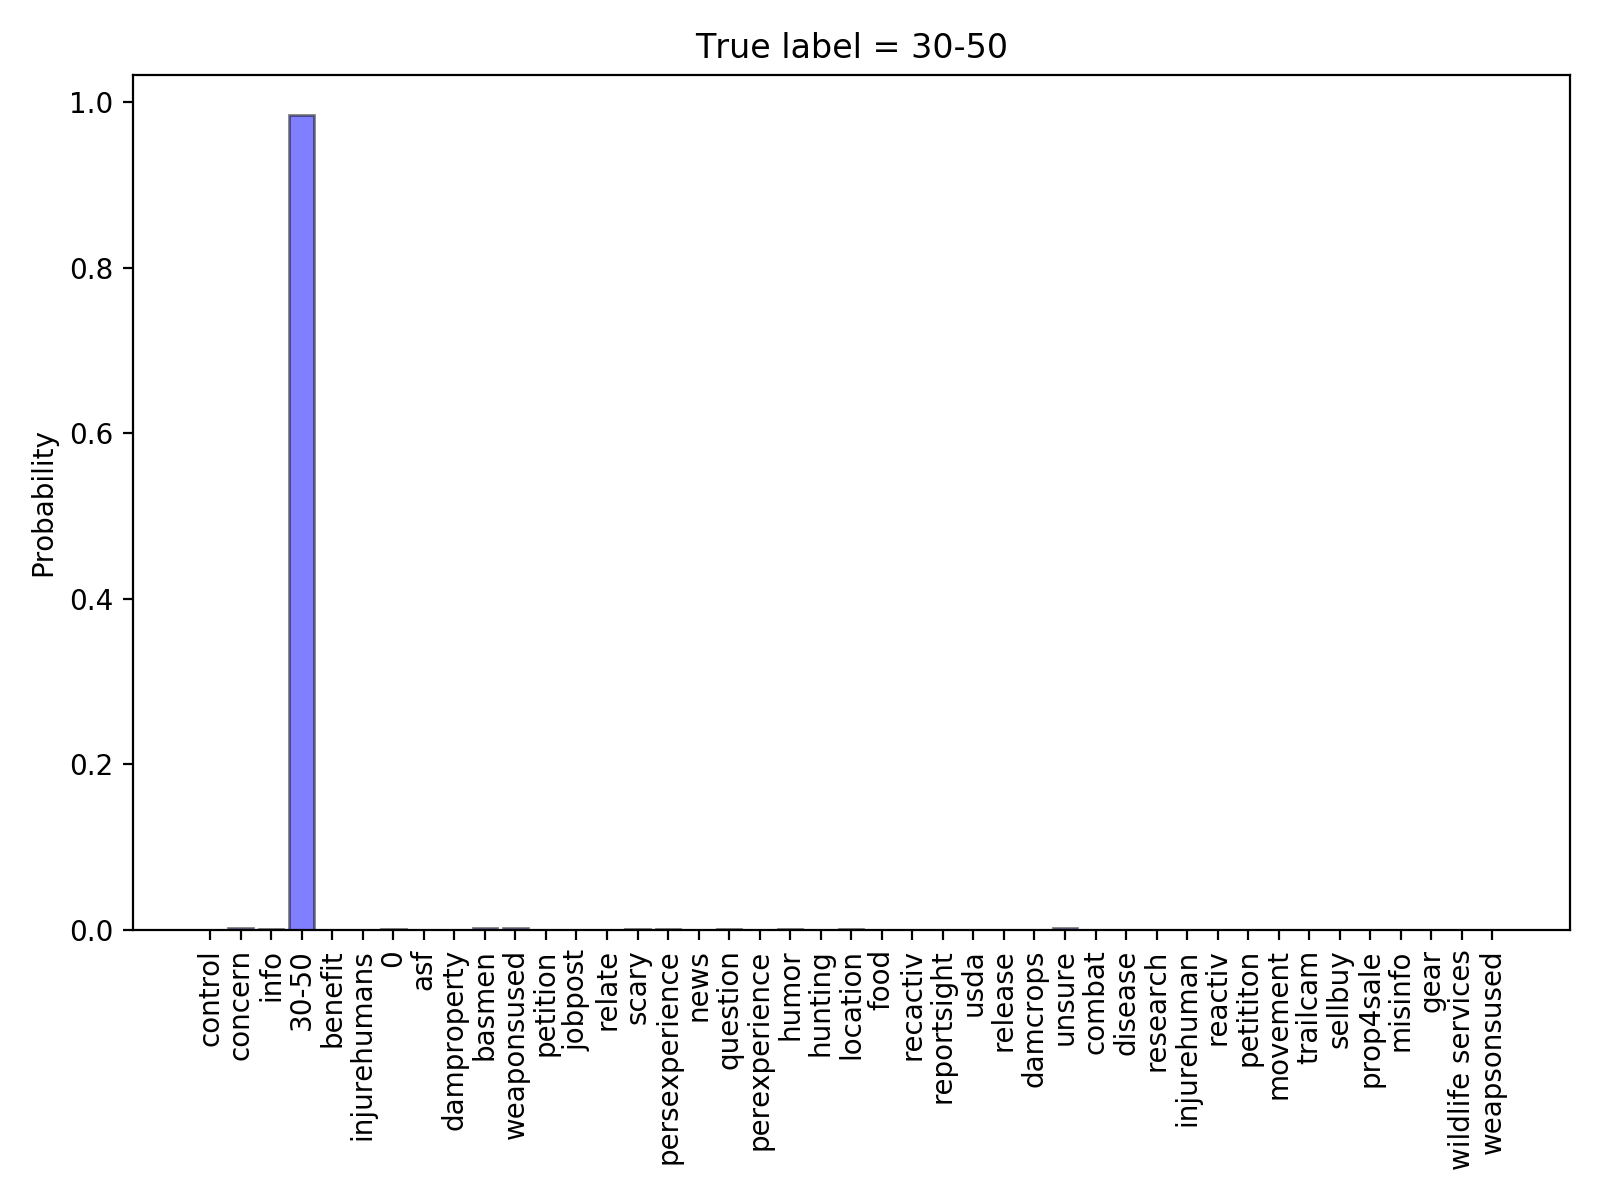

In [196]:
row = 5

y_val = np.concatenate(y_val_list)
probs = np.concatenate(probs_list)
plt.rcParams['figure.figsize'] = [8, 6]
target = y_val[row]
target_name = list(label_dict.keys())[list(label_dict.values()).index(target)]

%matplotlib notebook
fig, ax1 = plt.subplots(1)
barlist = ax1.bar(np.arange(len(unique_topics)), probs[row], color='blue', edgecolor='black', alpha=0.5)
for bar in barlist:
    bar.set_color('red')
ax1.title.set_text('True label = ' + target_name)
ax1.set_ylabel('Probability')
ax1.set_xticks(np.arange(len(unique_topics)))
ax1.set_xticklabels(list(label_dict.keys()), rotation = 90)
plt.tight_layout()
plt.show()

---